<p style="text-align: right">
  <img src="../images/dtlogo.png" alt="Logo" width="200">
</p>

# 💻 🚙 05 - PID: Heading control

A controller outputs commands that can be executed by our robot to achieve a certain goal. For example, in the case of the Duckiebot, the control signals are the linear velocity $v$ and angular velocity $\omega$ of the robot. 

The **P**roportional-**I**ntegral-**D**erivative (PID) controller is an example of a feedback controller where we use an output ($y_t$) of the system to measure tracking errors ($e_t$), that evolve in time, from some reference signal ($r_t$) to alter the control signals ($u_t$), so that the errors are driven to lower values (ideally zero) in time.

<figure>
  <div style="text-align:center;">
  <img src="../images/pid-control/pid-control-diagram.jpg" alt="pid-loop-2" style="width: 300px;"/>
  <figcaption>A PID control loop.</figcaption>
  </div>
</figure>

Consider a Duckiebot driving in the middle of a road with a constant linear velocity. Let's say our goal is to make sure the robot stays in the middle of the lane by adjusting its angular velocity. Intuitively, whenever the robot deviates from the middle of the lane, we will adjust the angular velocity so the robot turns toward the middle of the lane. The question is: by how much?

The name proportional-integral-derivative comes from the fact that the controller adjusts the control signals proportionally to the error at every time instant, while also considers the integral of the error over time (i.e., the accumulation, or sum, of error over time), and the derivative of the error at each time step (i.e., the rate of change of the error over time). The control command is calculated by considering the combination of these three components:

$$ u_t = k_p e(t) + k_i \int_0^t e(\tau) d \tau + k_d \frac{d e_t}{dt},$$

where $k_p$, $k_i$, and $k_d$ denote the proportional, integral, and derivative coefficients of the controller, respectively. 

The PID control problem is to determine values for these parameters (e.g., via trial and error) until the closed loop system performs reasonably well. Typically (but it depends strongly on the complexity of the system):

- Increasing $k_p$ will decrease the the time it takes for the system to approach the reference point (i.e., rise time), but at the risk of overshooting. 
- Increasing $k_d$ will help to decrease this overshooting by preventing the robot from moving too quickly in a direction that increases the error. 
- Increasing $k_i$ will help us to eliminate the steady-state error (i.e., the remaining error that we have when the system has converged), and compensate for unexpected external stimuli during operation.

For example, we can start by only adjusting $k_p$ while keeping $k_i=0$ and $k_d=0$ until the controller is somewhat able to reach the target. We can then fix $k_p$ at this value, and start adjusting $k_d$. Once we found a good value of $k_d$, that reduces the oscillations without slowing the system response down too much, we can proceed to adjust $k_i$ as needed to mitigate steady state errors.

While the above approach to tune our PID controller may work in practice, there is **no guarantee** that our robot will be stable (e.g., it may oscillate around or even completely diverge from the reference point). 

There are many approaches for designing PID controllers in a formal way and obtaining those guarantees. Talking about them though would require introducing more advanced system modeling methods (e.g., linearization, linear time-invariant systems, state-space representations, transfer functions), as well as analysis methods for dynamic systems (e.g., Bode diagrams, Nyquist plots, root locus) and synthesis techniques (e.g., loop shaping, pole placement), for actually determining the coefficients. There is a vast literature on PID control, and new variations on the theme are published every year although it is already a very established method. A video introduction to control systems can be found online, e.g., in the [Control Systems I](https://video.ethz.ch/lectures/d-mavt/2018/autumn/151-0591-00L/6a74fd84-5047-4639-b640-3ab2e6937e8a.html) course held at ETH Zurich.   

The popularity of PID control is due to the fact, amongst other factors, that these formal methods are not necessary to reach a satisfactory outcome. "Rule of thumb" methods such as the Ziegler-Nichols can help us to tune our PID controller, but trail and error (or, "synthesis by iterations", a. k. a. "tweak until death") works, too!

Let's go ahead and design a PID controller!

## Let's get started!

In this activity we will design a proportional, integrative, derivative (PID) controller to regulate the heading ($\theta_t$) of a Duckiebot, while it is driving at a constant linear speed ($v_0$). 

In reference to the PID control diagram above, we consider the following:

* $r_t = \theta_{ref,t} = \theta_{ref}$: the reference signal is a constant angle, expressed in radians
* $\hat y_t = \hat \theta_t$: the controlled variable is the heading of the Duckiebot. This controller controller will estimate it's heading based on the odometry model deigned in the [odometry activity](../05-Odometry/odometry_activity.ipynb), so make sure you're happy about that before proceeding! 
* $u_t = [v_0, \, \omega]^T$: the output of the controller, and input to the plant, will be two variables. The first will be the linear speed of the robot, which we will assume constant throughout this activity. The variable we will control is the angular rate ($\omega_t = \dot \theta_t = \frac{d \theta_t}{dt})$.

The objective of this activity is to determine the values of $k_p, k_i, k_d$ such that we obtain "good" tracking performances.

Before we go coding away, we must realize how computers calculate inetgrals and derivatives.

### Calculating integrals in discrete time

The theory tells us that one of the component signals of the PID controller is proportional to the integral of the error over time:

$$ e_{int}(t) = k_p \int_0^t e(\tau) d\tau $$

An integral is an _infinite_ (pick the biggest number you can think of, infinite is strictly more than that) **sum** of _infinitesimal_ (pick a positive number, the smallest you can think of. Infinitesimal is stricly smaller than that) bits, a concept that assumes _continuity_ of time. That is, for any two instant in time you can think about, there will always be infinite others in between.

But all computers in the world, including the one running on the Duckiebot, don't know how to do infinite or infinitesimal. They can only do finite. Time, for a robot, is a sequence of instants - but if you take two consecutive ones, there is nothing in between. Computers have notion of _discrete_ time, not continuous.

The immediate repercussion of this fundamental limitation of computers is that we cannot really calculate integrals. 

What we can do, is calculating a _finite sum_ to approximate the integral. 

$$ e_{int}(t) = k_p \int_0^t e(\tau) d\tau \simeq \sum_{i=0}^{k} e_i \Delta t = (e_0 + e_1 + \dots + e_{k-1} + e_k)\Delta t$$

Where in the above approximation we assumed for simplicity that all time instants are equally spaced by a constant _time step_ $\Delta t$.

So how do we implment this integral component on our Duckiebots? We can note that:

$$ e_{int,k}= (e_0 + e_1 + \dots + e_{k-1} + e_k)\Delta t = (e_0 + e_1 + \dots + e_{k-1})\Delta t + e_k\Delta t = e_{int,k-1} + e_k \Delta t.$$

In [1]:
import numpy as np

# How to calculate the integral term of the tracking error?

e_int_last = 0 # previous integral error, starts at 0
k = 10 # example current time step 
e = np.ones(k) # assume the error is constant at every time instant (it will not be)
dt = 0.1 # example sampling time (seconds)

for i in range (0, k):
    ei = e[i] # error at this time instant
    e_int_current = e_int_last + ei * dt # integral error at the previous instant plus the new increment
    e_int_last = e_int_current # the present because the past of the future
    
print(f"The finite sum of the tracking error is {e_int_current}")

The finite sum of the tracking error is 0.9999999999999999


### Calculating derivatives in discrete time

Derivates are the tool math uses to measure change. As you might imagine, they're tremendously important operations as so many things in the universe change in some way. 

Time derivatives are defined as the ratio of the difference of a function, evaluated at two infinitesimaly close to each other instants, and the time difference between them. In fancy words, derivates are _limits of the incremental ratio_ of a function. 

$$ \frac{de_t}{dt} = \lim_{dt \rightarrow 0} \frac{e_{t+dt}-e_t}{dt}$$

Without getting in the details, that $\lim$ part means that the $dt$ time difference is a very, very, small (positive) number. How small? The smaller you can imagine it, the better you understood the derivative operation. _At the limit, it's zero_.  

But computers can't do this "at the limit" qualitative jump. This is a very human thing we do. Computer only know finite time. So they need to know how much is actually $dt$ equal to (0.001? 0.0000001? or maybe even smaller that that?).

Computer can't do derivatives, they can do _finite differences_, which approximate derivatives. There are many different formulations of finite differences, the simplest is called "Euler backwards" method. It basically approximated the derivative as a difference of the current and the previous function evaluation, and divide it by the time step. 

$$\frac{de_t}{dt} \simeq e_{der,k} = \frac{e_k - e_{k-1}}{dt}.$$

Let's try it out!

In [2]:
e_der_ = [0.0] # to initialize the derivative term

for i in range (1, k): # note how we start from 1, we can't calculate the derivative at the first instant, because we need two discrete pieces of data
    e_current = e[i] # error at this time instant
    e_previous = e[i-1]
    e_der = (e_previous - e_current)/dt
    e_der_.append(e_der) 

print(f"The finite difference of the tracking error is {e_der_}")

The finite difference of the tracking error is [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


We now have all the tools to write our first PID controller! Remember that the objective is controlling the heading of the robot, by coputing an angular speed of the robot, while the linear speed is a constant. 

⚠️ ***WARNING:***
- DO NOT CHANGE THE NAME OF THE FOLLOWING FUNCTION
- DO NOT CHANGE THE ARGUMENTS OF THE FUNCTION
- DO NOT CREATE NEW CODE CELLS, THEY WILL NOT BE CONSIDERED

In [3]:
import numpy as np

# Heading control

# The function written in this cell will actually be ran on your robot (sim or real). 
# Put together the steps above and write your PIDController function! 
# DO NOT CHANGE THE NAME OF THIS FUNCTION, INPUTS OR OUTPUTS, OR THINGS WILL BREAK

# TODO: write your PID function for heading control!

def PIDController(v_0, theta_ref, theta_hat, prev_e, prev_int, delta_t):
    """
    Args:
        v_0 (:double:) linear Duckiebot speed (given).
        theta_ref (:double:) reference heading pose
        theta_hat (:double:) the current estiamted theta.
        prev_e (:double:) tracking error at previous iteration.
        prev_int (:double:) previous integral error term.
        delta_t (:double:) time interval since last call.
    returns:
        v_0 (:double:) linear velocity of the Duckiebot 
        omega (:double:) angular velocity of the Duckiebot
        e (:double:) current tracking error (automatically becomes prev_e_y at next iteration).
        e_int (:double:) current integral error (automatically becomes prev_int_y at next iteration).
    """
    
    # TODO: these are random values, you have to implement your own PID controller in here
    
    # calculate error, integral error, and derivative error
    e = theta_ref - theta_hat
    e_int = prev_int + e*delta_t
    e_der = (e - prev_e) / delta_t

    # preventing the integral error from growing too much (idea from solutions)
    e_int = max(min(e_int,2),-2)

    # PID coefficients
    Kp = 5
    Ki = 0.2
    Kd = 0.1

    # determine omega by PID control
    omega = Kp*e + Ki*e_int + Kd*e_der
    
    return [v_0, omega], e, e_int

### Sanity check

With this unit test you can do a quick test of your controller defined by the coefficients above. You can redefine the kinematic parameters as you wish to play around with various factors. We simulate a case without and with synthetic noise added to the measurements. 

You can find the definition of this test in the [unit_test](./unite_test.py) function. 

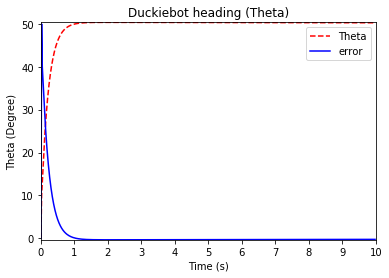

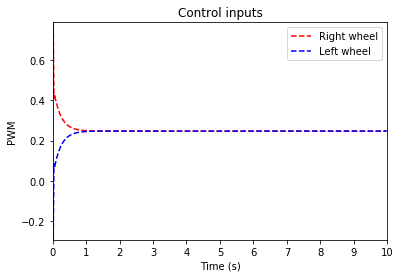

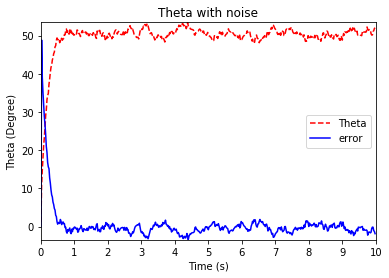

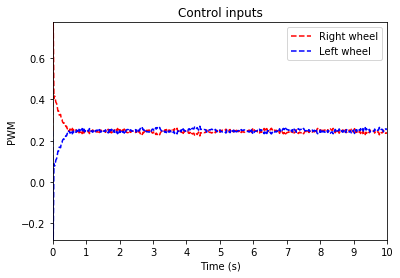

In [4]:
import matplotlib.pyplot as plt
import numpy as np 

import sys
sys.path.append('../')
from unit_test import UnitTestHeadingPID

# This is for quick testing purposes only - you can try different values of v_init and R, L or the ones you determined before. Try to change R, L for fun.
v_test = 0.2
R_test = 0.018 # m
baseline_test = 0.1 # m
gain_test = 0.6 
trim_test = 0 
thata_ref= np.deg2rad(50) # in rad

# Sanity check (not a faithful representation of the actual behavior, given the motion model is assumed to be exactly known)
unit_test = UnitTestHeadingPID(R_test, baseline_test, v_test,thata_ref, gain_test, trim_test, PIDController) # TODO: Vincenzo - make R, L inputs to this unit testing function
unit_test.test()


## 💻 Test the controller against the simulator

1. Open a terminal on your computer, and type 

       dts exercises build


2. Wait for the build to finish, then type:

       dts exercises test --sim


3. Open VNC on you browser and click on the `PID` icon on your desktop. You will see the following open (it might take ~30second or more, depending on the specifications of your computer):

    - A preconfigured RVIZ: to visualize performance
    - an LX terminal: `Ctrl-C` here to return to VNC. 
    - an interaction window with fields `ref` and and `v_0`, and buttons `Send Commands` and `Stop`. 


In the RVIZ terminal you should see what the robot sees. Nothing should be moving. You will see some debugging data in the terminal running on your computer where you launched the activity from. 

To initialize the testing of your controller, you will have to insert values for `ref` (in **degrees**) and `v_0` (between -1 and 1) and press on `Send Commands`. The controller you designed above will then start computing the $\omega$ and the robot will start driving. 

Good example values for this activity are $ref = 10$ and $v_0 = 0.2$, but you can play with these parameters at runtime and see how your PID controller performs. Mind that you will go wasted if you crash, or exit the map. In which case, start the instance again. 

<figure>
  <div style="text-align:center;">
  <img src="../images/pid-control/pid-sim-start.png" alt="pid-heading-sim-1" style="width: 500px;"/>
  <figcaption>The PID activity interface on VNC.</figcaption>
  </div>
</figure>

At any point you can press the `Stop` button to "emergency break" your Duckiebot. 

<figure>
  <div style="text-align:center;">
  <img src="../images/pid-control/pid-heading-ctrl-sim.png" alt="pid-heading-sim-2" style="width: 500px;"/>
  <figcaption>Switching reference between $\pm 10^\circ$ at increasing velocities.</figcaption>
  </div>
</figure>

To test different solutions, change the `PIDController()` function above, save this file (`Ctrl-S`) and re-run the activity with `dts exercises test --sim`. Remember that the odometry functions you wrote before play an important role here too as the tracking errors are computed based on the odometry.

### 🚙 Test the controller on your Duckiebot

1. Open a terminal on your computer, and type 

       dts exercises build


       
2. Wait for the build to finish, then type:

       dts exercises test -b ROBOTNAME


3. Follow the same instructions at point 3. of the simulation case. 

Note: we suggest to start at very slow speeds with the physical Duckiebot, and get a hang of the interface first. Going wasted in simulation is just a matter of re-setting the instance. Having the Duckiebot go wasted in the physical world might be significantly more time consuming!

<figure>
  <div style="text-align:center;">
  <img src="../images/pid-control/pid-heading-control-real.png" alt="pid-heading-real-1" style="width: 300px;"/>
  <figcaption> DB21M Duckiebot heading control. $v_{0} = 1$, $\theta_{ref} = [0, 90^\circ, 180^\circ, 270^\circ, 0^\circ]$ </figcaption>
  </div>
</figure>

To test different solutions, change the `PIDController()` function above, save this file (`Ctrl-S`) and re-run the activity with `dts exercises test -b ROBOTNAME`. Remember that the odometry functions you wrote before play an important role here too as the tracking errors are computed based on the odometry.

### 💡 Reflecting on the experience

After having played around with the PID controller, maybe testing different PID coefficients along with Duckiebot fixed speeds and distances to the reference trajectories, you might have noticed a few things:

- Need for tuning: There is a coupling between stability, performance, coefficients and magnitude of the tracking error. A set of coefficients that worked "well" for a given linear speed and distance from the reference, might not work as well with a different set of values. PID control _can_ produce good results, but it requires tuning to specific cases. 

- Input saturations: real robots have saturations (e.g. `omega_max` in the kinematics parameters, which has been set in previous activities). This means that occasionally having the controller act more aggressively will not change the system's response, as there are other real world constraints. Saturations might represent physical limitations of hardware (intuitively, the higher the value of the input, the higher "energy" it will take to actuate that command. Energy is not free, nor infinitely available.), or overarching safety constraints that have been put in place to prevent dangerous things from happening. When inputs saturate, errors (especially the integral one) might continue building up, causing a situation that will break the logic of the PID controller. For this reason, typically `anti wind-up` mechanisms are implemented to prevent either input saturation, of the integral error building up too much. There are many fancy `anti wind-up` strategies; we implemented a simple one in the controller above. 

- You never get perfect tracking, even with a very well tuned PID controller. Why? 

- The robot doesn't have the slightest idea of what is going on around him. This is beacause we are using interoceptive sensors (wheel encoders) to create the robot's belief. The **real** state of the robot is unknown to it. Moreover, lack of exteroceptive sensors (e.g., a camera) makes the robot unable to "anchor" its belief to some real-world feature, and perform sanity checks. You might have noticed that a Duckiebot will _not_ take that turn in your Duckietown autonomously, and that's because it has no notion of a map. For this very reason we will introduce cameras and computer vision in the next module. 